In [1]:
#!/usr/bin/env python
# coding: utf-8

#------------------------------------------------------------------------------
#Set Seed
#------------------------------------------------------------------------------

import random

random.seed(2020)
print(random.random())

#------------------------------------------------------------------------------
#Detect number of cores on computer (needed for multicore processing to speed up code)
#------------------------------------------------------------------------------

import psutil
psutil.cpu_count()
psutil.cpu_count(logical=False)  # Ignoring virtual cores

#------------------------------------------------------------------------------
#Set working directory
#------------------------------------------------------------------------------
import os

#------------------------------------------------------------------------------
#Import relevant packages
#------------------------------------------------------------------------------

import pandas as pd
import os
from pprint import pprint
import csv

from dateutil.parser import parse
from pandas import DataFrame

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# spacy for lemmatization
import spacy
from nltk.stem.wordnet import WordNetLemmatizer

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline





0.6196692706606616


In [2]:
#------------------------------------------------------------------------------
#Prepare stopwords
#------------------------------------------------------------------------------

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['using', 'publication', 'ltd', 'elsevier', 'reserved', 'rights'])

#------------------------------------------------------------------------------
#Import newspaper articles
#------------------------------------------------------------------------------
import glob
import docx

#define blank list
words = []

#define function to import USAT, NYT, WaPo
def list_files(dir):                                                                                                  
    r = []                                                                                                            
    subdirs = [x[0] for x in os.walk(dir)]                                                                            
    for subdir in subdirs:                                                                                            
        files = os.walk(subdir).__next__()[2]                                                                             
        if (len(files) > 0):                                                                                          
            for file in files:
                if "Bibliography" in file:
                    continue
                if("doclist" in file):
                    continue
                if(".docx" in file):
                    r.append(os.path.join(subdir, file))                                                                         
    return r                                                                                                          


file_list = list_files("/Users/Mihir/Downloads/Sample/")
#file_list = list_files("/Users/anavirshermon/Dropbox (Kenan-Flagler)/Newspaper Analysis/Sample/")

#import wsj articles, which are in an excel sheet
wsj      = pd.read_excel("/Users/Mihir/Downloads/Sample/wsj.xlsx", engine='openpyxl') 
wsj      = wsj[wsj['Content'].notna()]

wsj['year'] = wsj['date'].dt.year #extract year

wsj_1    = wsj[(wsj['year']<=2012)]
wsj_2    = wsj[(wsj['year']>2012) & (wsj['year']<= 2015)]
wsj_3    = wsj[(wsj['year']>=2016)]

wsj_list   = wsj['Content'].tolist()
wsj_1_list = wsj_1['Content'].tolist()
wsj_2_list = wsj_2['Content'].tolist()
wsj_3_list = wsj_3['Content'].tolist()

    
#add words to files list
for i in file_list:
    doc = docx.Document(i)
    words.append([p.text for p in doc.paragraphs]) 
        
#making each word in paragraph formation and removing all words that come before "Body", which tells us when the paragraph begins
for i in range(len(words)):
    words[i] = ' '.join(words[i])
    #words[i] = words[i][words[0].index("Body "):]
    
one = []
two = [] 
three = []

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/site-packages/docx/section.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Sequence


In [3]:

#split up files between dates
for i in words:
    date =parse(i[i.index("Load-Date:") + 11:i.index("End of Document")])
    if(date.year<=2012):
        one.append(i)
    elif(date.year<=2015):
        two.append(i)
    else:
        three.append(i)

words_cleaned = [x.rsplit("Body ")[1] for x in words]
words_cleaned = [x.split("Load-Date")[0] for x in words_cleaned]
words_cleaned = [x for x in words_cleaned if str(x) != 'nan']

one_cleaned = [x.rsplit("Body ")[1] for x in one]
one_cleaned = [x.split("Load-Date")[0] for x in one_cleaned]
one_cleaned = [x for x in one_cleaned if str(x) != 'nan']

two_cleaned = [x.rsplit("Body ")[1] for x in two]
two_cleaned = [x.split("Load-Date")[0] for x in two_cleaned]
two_cleaned = [x for x in two_cleaned if str(x) != 'nan']

three_cleaned = [x.rsplit("Body ")[1] for x in three]
three_cleaned = [x.split("Load-Date")[0] for x in three_cleaned]
three_cleaned = [x for x in three_cleaned if str(x) != 'nan']

for i in wsj_list:
    words_cleaned.append(i)  

for i in wsj_1_list:
    one_cleaned.append(i)
    
for i in wsj_2_list:
    two_cleaned.append(i)
    
for i in wsj_3_list:
    three_cleaned.append(i)

#------------------------------------------------------------------------------
#Drop military related newspaper articles
#------------------------------------------------------------------------------

#Code to eventually use tf-idf or some systematic method to drop military articles
from pandas import DataFrame
import re

#drop articles if they contain these words
# =============================================================================
# drop_words    = {'military', 'strike', 'attack', 'syria', 'iran', 'pakistan'}
# words_cleaned = [i for i in words_cleaned if not any(x in i for x in drop_words)]
# one_cleaned   = [i for i in one_cleaned if not any(x in i for x in drop_words)]
# two_cleaned   = [i for i in two_cleaned if not any(x in i for x in drop_words)]
# two_cleaned = [i for i in three_cleaned if not any(x in i for x in drop_words)]
# 
# =============================================================================

drop_words= {'military', 'strike', 'attack', 'syria', 'yemen', 'pakistan', 'afghanistan', 'taliban', 'pentagon', 'islamic'}

#convert to lower case
data        = [item.lower() for item in words_cleaned]
data_one    = [item.lower() for item in one_cleaned]
data_two    = [item.lower() for item in two_cleaned]
data_three  = [item.lower() for item in three_cleaned]

#remove new line characters
#data = [re.sub('\s+', ' ', sent) for sent in data]   # Remove new line characters

#tokenize and pre-process the text
def split(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
data        = list(split(data))
data_one    = list(split(data_one))
data_two    = list(split(data_two))
data_three  = list(split(data_three))


#remove numbers, but not words that contain numbers
data       = [[token for token in doc if not token.isnumeric()] for doc in data]
data_one   = [[token for token in doc if not token.isnumeric()] for doc in data_one]
data_two   = [[token for token in doc if not token.isnumeric()] for doc in data_two]
data_three = [[token for token in doc if not token.isnumeric()] for doc in data_three]

#remove words that are only two characters
data       = [[token for token in doc if len(token) > 2] for doc in data]
data_one   = [[token for token in doc if len(token) > 2] for doc in data_one]
data_two   = [[token for token in doc if len(token) > 2] for doc in data_two]
data_three = [[token for token in doc if len(token) > 2] for doc in data_three]

#remove stopwords
def remove_stopwords(words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in words]
data       = remove_stopwords(data)
data_one   = remove_stopwords(data_one)
data_two   = remove_stopwords(data_two)
data_three = remove_stopwords(data_three)


# =============================================================================
# from collections import Counter 
# test = Counter(c for clist in data for c in clist)
# most_occur = test.most_common(150)
# 
# =============================================================================


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
print(len(data))
print(len(data_one))
print(len(data_two))
print(len(data_three))

2498
668
1121
709


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import nltk
from nltk.corpus import wordnet as wn
nouns = {x.name().split('.', 1)[0] for x in wn.all_synsets('n')}
verbs = {x.name().split('.', 1)[0] for x in wn.all_synsets('v')}


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
for i in range(len(data)):
    data[i] = [w for w in data[i] if w in nouns]
for i in range(len(data_one)):
    data_one[i] = [w for w in data_one[i] if (w in nouns or w in verbs)]
for i in range(len(data_two)):
    data_two[i] = [w for w in data_two[i] if (w in nouns or w in verbs)]
for i in range(len(data_three)):
    data_three[i] = [w for w in data_three[i] if (w in nouns or w in verbs)]

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
'''
These lines combine all of the data into paragraph form so that it can be read by the tfidf vector class. They are then split back afterwards.
'''
data = [' '.join(w) for w in data]
data_one = [' '.join(w) for w in data_one]
data_two = [' '.join(w) for w in data_two]
data_three = [' '.join(w) for w in data_three]
loop = [data, data_one, data_two, data_three]

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
names = ["data", "data_one", "data_two", "data_three"]
group = [data, data_one, data_two, data_three]
d = {}
'''
Creates the td-idf vectors for the total (data), 2012-2015 (data_one), 2015-2017 (data_two), 2017+(data_three)
and stores in the a dictionary (d)
'''
for i, j in zip(names, group):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(j)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    d[i] = df

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
''' 
Splits data again 
'''
data = [i.split() for i in data]
data_one = [i.split() for i in data_one]
data_two = [i.split() for i in data_two]
data_three = [i.split() for i in data_three]
res = {}

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
#Gets the top 40 words for each of the tf-idf vectors and stores it in the dictionary (res)
for n, i in zip(names, d):    
    array = []
    for j in d[i].iterrows():
         array.append((j[1].sort_values(ascending=False)[:40].keys().tolist()))
    res[n] = array

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
#Drops document if the top 40 words is in drop_words array
data = [data[i] for i in range(len(data)) if not any (x in res['data'][i] for x in drop_words)]
data_one = [data_one[i] for i in range(len(data_one)) if not any (x in res['data_one'][i] for x in drop_words)]
data_two = [data_two[i] for i in range(len(data_two)) if not any (x in res['data_two'][i] for x in drop_words)]
data_three = [data_three[i] for i in range(len(data_three)) if not any (x in res['data_three'][i] for x in drop_words)]

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
#Saves data
pd.DataFrame(res['data']).to_csv("total.csv")

/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['sunday', 'front', 'small', 'crowd', 'shopping', 'south', 'central', 'four', 'young', 'goggles', 'race', 'front', 'banner', 'drone_racing_league', 'bell', 'following', 'logic', 'element', 'weight', 'small', 'four', 'miniature', 'front', 'facing', 'camera', 'two', 'flight', 'appearance', 'buzz', 'sound', 'somewhere', 'bumblebee', 'dentist', 'drill', 'environment', 'commerce', 'hawthorne', 'plaza', 'time', 'given', 'large', 'neon', 'cut', 'gloom', 'racing', 'gate', 'course', 'alarm', 'rose', 'forward', 'speed', 'escalator', 'second', 'floor', 'checkpoint', 'vertical', 'hairpin', 'turning', 'racing', 'back', 'past', 'master', 'curtain', 'safety', 'netting', 'crowd', 'see', 'straight', 'corridor', 'audience', 'attention', 'rounding', 'final', 'turn', 'two', 'floor', 'series', 'announcer', 'action', 'system', 'pair', 'aircraft', 'final', 'gate', 'victor', 'finish', 'arm', 'length', 'rival', 'minute', 'drone', 'hit', 'netting', 'audience', 'name', 'fist', 'air', 'man', 'blind', 'world', 'c

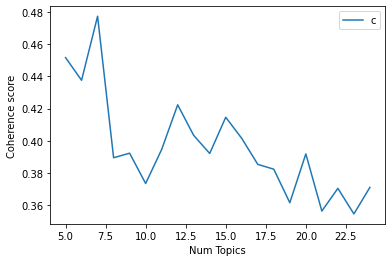

Num Topics = 5  has Coherence Value of 0.4516
Num Topics = 6  has Coherence Value of 0.4376
Num Topics = 7  has Coherence Value of 0.4773
Num Topics = 8  has Coherence Value of 0.3895
Num Topics = 9  has Coherence Value of 0.3924
Num Topics = 10  has Coherence Value of 0.3736
Num Topics = 11  has Coherence Value of 0.3947
Num Topics = 12  has Coherence Value of 0.4224
Num Topics = 13  has Coherence Value of 0.4034
Num Topics = 14  has Coherence Value of 0.3922
Num Topics = 15  has Coherence Value of 0.4146
Num Topics = 16  has Coherence Value of 0.4015
Num Topics = 17  has Coherence Value of 0.3854
Num Topics = 18  has Coherence Value of 0.3824
Num Topics = 19  has Coherence Value of 0.3616
Num Topics = 20  has Coherence Value of 0.3919
Num Topics = 21  has Coherence Value of 0.3565
Num Topics = 22  has Coherence Value of 0.3706
Num Topics = 23  has Coherence Value of 0.3547
Num Topics = 24  has Coherence Value of 0.3712
now creating file topic_terms5_2013-2015.csv
now creating file to

In [12]:

#create bigrams and trigrams
bigram         = gensim.models.Phrases(data, min_count=5, threshold=10)
trigram        = gensim.models.Phrases(bigram[data], threshold=10)
bigram_mod     = gensim.models.phrases.Phraser(bigram)
trigram_mod    = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

data_bigrams    = make_bigrams(data)
data_trigrams   = make_trigrams(data)

data_one_trigrams   = make_trigrams(data_one)
data_two_trigrams   = make_trigrams(data_two)
data_three_trigrams = make_trigrams(data_three)

#lemmatize words
lemmatizer = WordNetLemmatizer()
data_lemmatized = [[lemmatizer.lemmatize(token) for token in doc] for doc in data_trigrams]

print(data_lemmatized[99:100])

data_one_lemmatized   = [[lemmatizer.lemmatize(token) for token in doc] for doc in data_one_trigrams]
data_two_lemmatized   = [[lemmatizer.lemmatize(token) for token in doc] for doc in data_two_trigrams]
data_three_lemmatized = [[lemmatizer.lemmatize(token) for token in doc] for doc in data_three_trigrams]

data_lemmatized = data_two_lemmatized

group = "_2013-2015"

id2word = gensim.corpora.Dictionary(data_lemmatized)

id2word.filter_extremes(no_below=20, no_above=0.75)

texts = data_lemmatized
corpus = [id2word.doc2bow(doc) for doc in texts]

def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print("This simulation is current processing", num_topics, "topics")
        model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=num_topics, 
                        random_state=100,
                        chunksize=5,
                        passes=20,
                        per_word_topics=True,
                        workers = 5)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence()) 

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=5, limit=25, step=1)

#PLot coherence values 
limit=25; start=5; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


for x in range(5, 24):
    
    optimal_model = model_list[x-5]

    fn = "topic_terms" + str(x) + group + ".csv"
    print(("now creating file ") + fn)
    if (os.path.isfile(fn)):
        m = "a"
    else:
        m = "w"
    
    num_topics=x
    # save topic, term, prob data in the file
    with open(fn, m, encoding="utf8", newline='') as csvfile:
        fieldnames = ["topic_id", "term", "prob"]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if (m == "w"):
            writer.writeheader()
    
        for topic_id in range(num_topics):
            term_probs = optimal_model.show_topic(topic_id, topn=35)
            for term, prob in term_probs:
                row = {}
                row['topic_id'] = topic_id
                row['prob'] = prob
                row['term'] = term
                writer.writerow(row)
topic_over_topic, annotation = optimal_model.diff(optimal_model, annotation=True)

topic_over_topic_speicherpfad = "topic_over_topic_similarity.csv"
pd.DataFrame(topic_over_topic).to_csv(topic_over_topic_speicherpfad, sep=';')